# Assignment 7 (Sound localization)
This noteboook solves the problems stated in the assignment

Author: Kaushik G Iyer (EE23B135)

## Imports
This notebook uses numpy and scipy to do the desired calculations. It uses matplotlib to plot the data.

Run `pip install numpy matplotlib` to install the required libraries.

NOTE: If you want to interpolate the sample data (with cubic splines), scipy will be required.

In [88]:
from typing import Any
import matplotlib.pyplot as plt
import numpy as np
np_array_t = Any

# Set to true to use cubic splining to interpolate the mic readings
# (If set to false then the closest sample less than the required sample is taken instead)
USE_CUBIC_SPLINES = False

# Generating sample data
Below is the first part of the assignment that includes generating sample microphone data for a given obstacle position.

In [ ]:
# This cell describes functions that are used to generate the data

def wsrc(t: np_array_t, SincP: float) -> np_array_t:
    """
    Function that produces the waveform created by the source
    NOTE: It is basically a sinc wave with narrowness determined by parameter SincP
    """
    return np.sinc(SincP*t) # type: ignore

def dist(src: tuple[float, float], pt: tuple[float, float], mic: float) -> float:
    """Distance from src to mic after reflecting through point"""
    # distance from src to pt
    d1 = sum((src[i] - pt[i])**2 for i in range(2))**0.5
    
    mic_coord = (0, mic)
    # distance from pt to mic
    d2 = sum((pt[i] - mic_coord[i])**2 for i in range(2))**0.5
    
    return d1 + d2

def generate_waveform_data(
        # Main system parameters: number of mics, number of samples in time
        Nmics: int = 64,
        Nsamp: int = 200,
        src: tuple[float, float] = (0, 0), # Source: x,y coordinates: x: 0+, y: [-Y, +Y] where Y determined by pitch and Nmics
        pitch: float = 0.1, # Spacing between microphones
        dist_per_samp: float = 0.1, # proxy for sampling rate
        C: float = 2, # Speed of sound in the medium
        SincP: float = 5, # Time dilation factor for sinc pulse: how narrow
        obstacle: tuple[float, float] = (3, -1), # Location of point obstacle
):
    """
    Generates the waveforms read by the mics due to the source alone and due to reflections from the obstacle
    """
    # Evenly distributed mics on the y axis
    mics = np.linspace(-(Nmics - 1) * pitch / 2, +(Nmics - 1) * pitch / 2, Nmics)
    
    # Nsamp time instants with spacing of dist_per_samp
    t = np.linspace(0, Nsamp * dist_per_samp, Nsamp, endpoint=False) / C
    
    # Waveform due to waves from source directly hitting mic
    source_rf = np.array([
        wsrc(t - abs(mic) / C, SincP) # There will be a time delay corresponding to distance / speed
        for mic in mics
    ])

    # Waveform due to waves from source hitting mic after reflecting from object
    reflected_rf = np.array([
        wsrc(t - dist(src, obstacle, mic) / C, SincP) # There will be a time delay corresponding to distance / speed
        for mic in mics
    ])

    return source_rf, reflected_rf


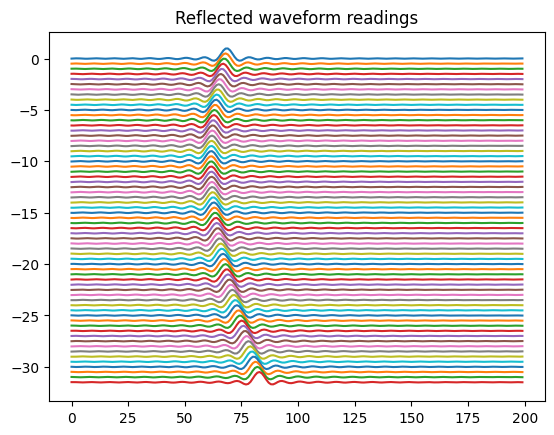

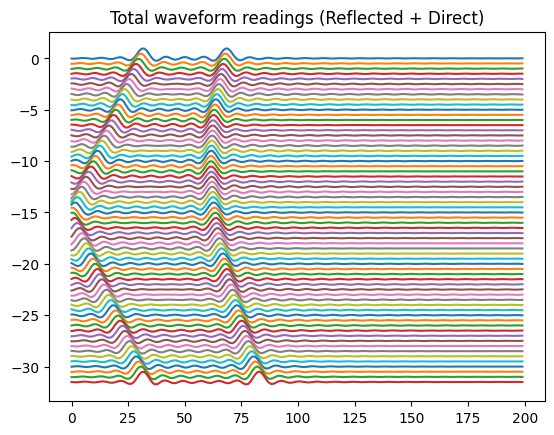

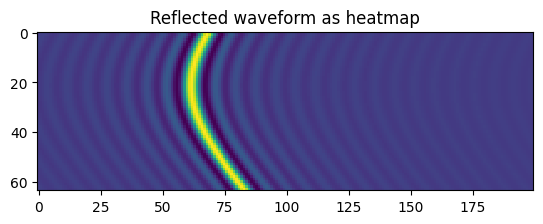

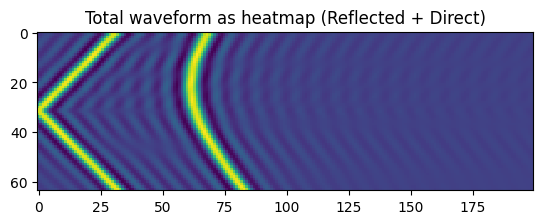

In [90]:
# This cell generates waveforms for the case described in the assignment
# Obstacle at (3, -1), Nmics = 64 and Nsamp = 200

source_rf, reflected_rf = generate_waveform_data(
    Nmics=64, Nsamp=200,
    C=2, pitch=0.1, dist_per_samp=0.1,
    obstacle=(3, -1)
)

plt.figure(1) # type: ignore
plt.title("Reflected waveform readings") # type: ignore
for i in range(len(reflected_rf)):
    # NOTE: The waveform for the mic with the lowest y value is on the top of this graph
    # (I've done it this way because the examples in the assignment also seem to do it this way)
    plt.plot(reflected_rf[i] - i * 0.5) # type: ignore

plt.figure(2) # type: ignore
plt.title("Total waveform readings (Reflected + Direct)") # type: ignore
for i in range(len(reflected_rf)):
    # NOTE: The waveform for the mic with the lowest y value is on the top of this graph
    # (I've done it this way because the examples in the assignment also seem to do it this way)
    plt.plot(source_rf[i] + reflected_rf[i] - i * 0.5) # type: ignore

plt.figure(3) # type: ignore
plt.title("Reflected waveform as heatmap") # type: ignore

# NOTE: The waveform for the mic with the lowest y value is on the top of this graph
# (I've done it this way because the examples in the assignment also seem to do it this way)
plt.imshow( # type: ignore
    reflected_rf, 
    cmap='viridis', interpolation='nearest'
)

plt.figure(4) # type: ignore
plt.title("Total waveform as heatmap (Reflected + Direct)") # type: ignore

# NOTE: The waveform for the mic with the lowest y value is on the top of this graph
# (I've done it this way because the examples in the assignment also seem to do it this way)
plt.imshow( # type: ignore
    source_rf + reflected_rf, 
    cmap='viridis', interpolation='nearest'
)

# Delay and Sum Algorithm
Below is the second part of the assignment that required us to use the DAS algorithm to reconstruct images from the waveform data.

In [91]:
# This cell describes functions that are used to generate the image

def reconstruct_image(
        readings: np_array_t,
        pitch: float = 0.1, # The distance between each mic
        dist_per_samp: float = 0.1, # A proxy for the sampling rate
        resolution: tuple[int, int] = (1, 1), # The number of extra points to test for while running the DAS algorithm (NOTE: Expected to be >= 1)
        src: tuple[float, float] = (0, 0),
        ):
    cubic_splines = []
    if USE_CUBIC_SPLINES:
        from scipy.interpolate import CubicSpline
        cubic_splines = [
            CubicSpline([*range(len(reading))], reading)
            for reading in readings
        ]

    assert resolution[0] > 0 and resolution[1] > 0, "Expect resolution to be tuple of whole numbers!"


    # Main system parameters: number of mics, number of samples in time
    Nmics = len(readings)
    assert Nmics > 0, "Expected atleast reading from 1 mic!"

    Nsamp = len(readings[0])
    assert Nsamp > 1, "Need atleast 2 samples for any meaningful calculation!"
    assert all(len(reading) == Nsamp for reading in readings), "Expected all mics to have the same number of samples!"

    mics = np.linspace(-(Nmics - 1) * pitch / 2, +(Nmics - 1) * pitch / 2, Nmics)

    # I create an image that covers the region from:
    # - The bottom most mic to the top most (in the y axis)
    # - 0 to Nsamp * dist_per_samp / 2 (in the x axis)
    image = np.zeros((Nmics * resolution[1], (Nsamp // 2) * resolution[0]))

    for i in range(Nmics * resolution[1]): # Iterate through every y coordinate
        # The y coordinate we are testing for
        y = mics[i // resolution[1]] + pitch * (i % resolution[1]) / resolution[1]
        
        for j in range((Nsamp // 2) * resolution[0]): # Iterate through every x coordinate
            x = j * dist_per_samp / resolution[0] # The x coordinate we are testing for

            for k in range(Nmics): # Iterate through every mic
                required_sample = dist(src, (x, y), mics[k]) / dist_per_samp
                if required_sample >= Nsamp:
                    # If we don't have data for the required sample, just assume its 0
                    image[i][j] += 0
                    continue

                if USE_CUBIC_SPLINES:
                    assert cubic_splines
                    image[i][j] += cubic_splines[k](required_sample)
                else:
                    image[i][j] += readings[k][int(required_sample)]

    return image


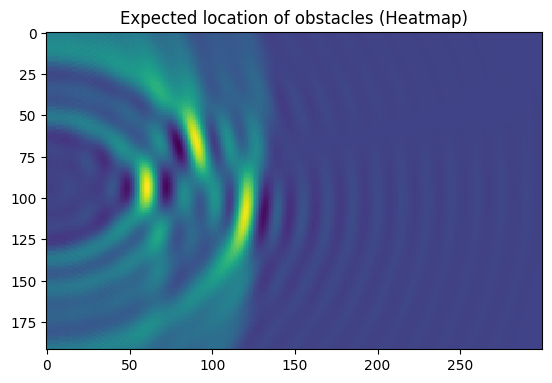

In [ ]:
# This cell plots the image for the data given in the assignment
# NOTE: Be sure to set the correct pitch and dist_per_samp values !

# Be sure to pass the correct path to the file with the data!
readings = np.loadtxt("rx3.txt")
image = reconstruct_image(
    readings,
    pitch=0.1, dist_per_samp=0.1,
    # NOTE: Increasing resolution increases the number of points tested for (The image will look less pixelated but it will take more time)!
    resolution=(1, 2)
)

plt.title("Expected location of obstacles (Heatmap)") # type: ignore
# Again the mic with the least y value corresponds to the topmost row of the image
# (Just to be consistent with the way the samples in the assignment are)
plt.imshow( # type: ignore
    image,
    cmap='viridis', interpolation='nearest'
)

# Answers to Questions
### Question 1: Sinc Pulse Generation
In order to generate the different sinc pulses (shown in the assignment), on can play around with the SincP constant change the width(periodicity) of the sinc signal :)

Increasing SincP makes the output signal seem narrower (Hence the generated heatmap images for said samples will have thinner bands), while decreasing SincP makes the output signal wider (Hence the bands will be wider)


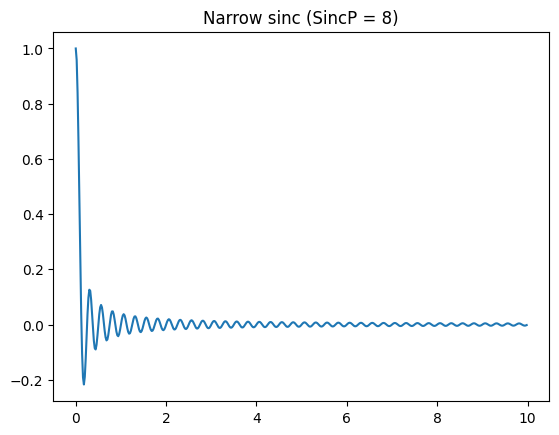

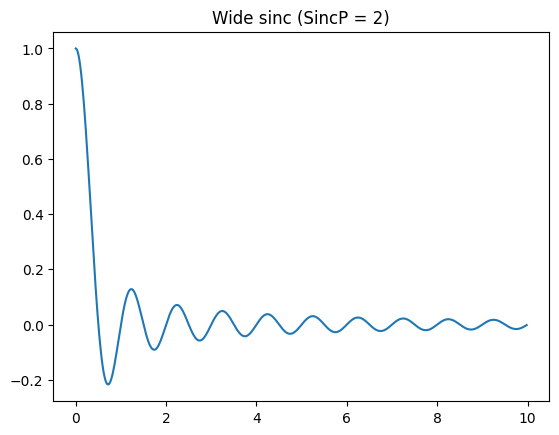

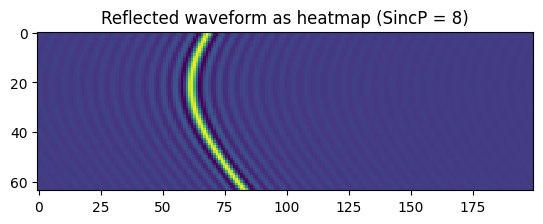

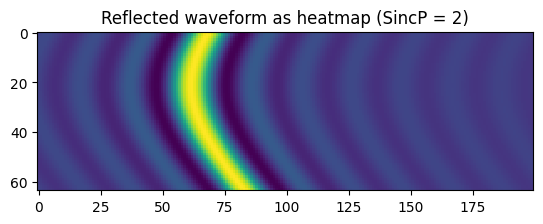

In [93]:
_, reflected_rf_higher_sincp = generate_waveform_data(SincP=8)
_, reflected_rf_lower_sincp = generate_waveform_data(SincP=2)

t = np.linspace(0, 10, 500, endpoint=False)
wide_sinc = wsrc(t, 2)
narrow_sinc = wsrc(t, 8)

plt.figure(1)
plt.title("Narrow sinc (SincP = 8)") # type: ignore
plt.plot(t, narrow_sinc)

plt.figure(2)
plt.title("Wide sinc (SincP = 2)") # type: ignore
plt.plot(t, wide_sinc)


plt.figure(3) # type: ignore
plt.title("Reflected waveform as heatmap (SincP = 8)") # type: ignore
plt.imshow( # type: ignore
    reflected_rf_higher_sincp, 
    cmap='viridis', interpolation='nearest'
)

plt.figure(4) # type: ignore
plt.title("Reflected waveform as heatmap (SincP = 2)") # type: ignore
plt.imshow( # type: ignore
    reflected_rf_lower_sincp, 
    cmap='viridis', interpolation='nearest'
)

### Question 2: Reasonable limits for image reconstruction
A slightly better limit to use is `Nsamp / 2`.

In order to reconstruct the image at a given point, there must be atleast 1 mic that has a reading corresponding to reflectino of source waveform from said point. It is easy to see that if the source is at 0, the furthest an object can be will be of the form x, 0 and the corresponding 'latest sample' will be read by the mic present at 0, 0.

No we have the equation 2 * x <= Nsamp * dist_per_sample (The factor 2 exists since the wave has to reflect back)
This gives us x <= Nsamp * dist_per_sample / 2, i.e It is enough to go uptil the distance corresponding to Nsamp / 2 :)

### Question 3: Intuition behind maximum amplitude being at (30, 22)

Since the obstacle was at 3, -1 we would expect the maxima to correspond to a coordinate of 3, -1

y coordinate 0 corresponds to the bottom most mic level, y coordinate 22 corresponds to the position of the 23rd mic from the bottom. The 23rd mic is at y coordinate -0.950000.
x coordinate of 30 corresponds to a position of 30 / 10 = 3.

i.e The maxima corresponds to a coordinate of 3, -0.95 (which approximately matches the 3, -1 that we expected)

### Question 4: Maximum x, y coordinate of obstacle that can still be reconstructed

For the image to be reconstructed one must be able to have atleast one reading of the reflected waveform by any of the mics.
i.e dist(obstacle, src) + dist(obstacle, mic) <= Nsamp * dist_per_samp for atleast 1 of the mics.

For point furthest away we get the locus to be one that follows:
$$
dist(obstacle, src) + dist(obstacle, mic) == Nsamp * dist\_per\_samp
$$

It is easy to see that these are just a bunch of ellipses, one may draw out said ellipses to find the exact locus of the furthest possible points the object can be to be reconstructed (It will be a non trivial shape)

An easier question to answer is the max(x coord) such that the obstacle can be reconstructed. Following similar logic to Question 2 we get $x <= \frac{Nsamp * dist\_per\_sample}{2}$. i.e The max x coord that can be reconstructed is Nsamp * dist_per_sample / 2.

Similarly to find the max(y coord) such that the obstacle can be reconstructed, we get $y + y - \frac{(Nmics - 1) * pitch} {2} <= Nsamp * dist\_per\_sample$.

i.e The max y coord is $\frac{(Nsamp * dist\_per\_sample + \frac{(Nmics - 1) * pitch}{2})}{2}$

### Question 5: Effect of C on the image

Below I have generated waveforms for 2 different c.
It is easy to see that for constant dist_per_samp and Nsamp, having a higher c means that the time values for which the microphones sample are much closer (higher c with const dist_per_samp implies higher sample rate)

A higher sampling rate means that more readings are taken with values of similar amplitude (i.e not much change per sample).
This is why the higher C image looks wider (and less sharp due to the difference between consecutive samples being relatively lower). While the one with the lower C has a lower sample rate which makes nearby samples more different from eachother (more visible contrast) which makes it look sharper 👍

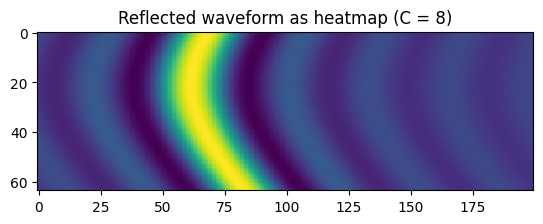

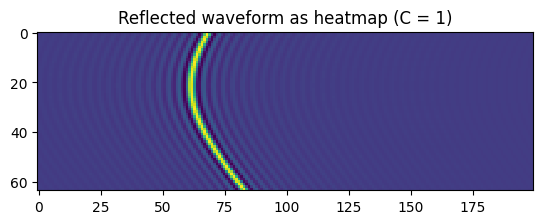

In [94]:
_, reflected_rf_higher_c = generate_waveform_data(C=8)
_, reflected_rf_lower_c = generate_waveform_data(C=1)

plt.figure(1) # type: ignore
plt.title("Reflected waveform as heatmap (C = 8)") # type: ignore
plt.imshow( # type: ignore
    reflected_rf_higher_c, 
    cmap='viridis', interpolation='nearest'
)

plt.figure(2) # type: ignore
plt.title("Reflected waveform as heatmap (C = 1)") # type: ignore
plt.imshow( # type: ignore
    reflected_rf_lower_c, 
    cmap='viridis', interpolation='nearest'
)

### Question 6: Testing out different values of Nmics and Nsamp

The more mics that are present, the more sure we can be of where the obstacle is in the reconstructed image (The region of high amplitude in the image is smaller). (This also makes sense intuitively as we basically have more information to work with). 

Increasing Nsamp is only beneficical if the obstacle is placed further away, since I have tested for the obstacle being realtively close by (i.e It is able to be reconstructed for all the ranges of Nsamp), the use of Nsamp may not be evident.

It is important for Nsamp to be big enough to cover the location of the object, anything above this threshold value is not required.

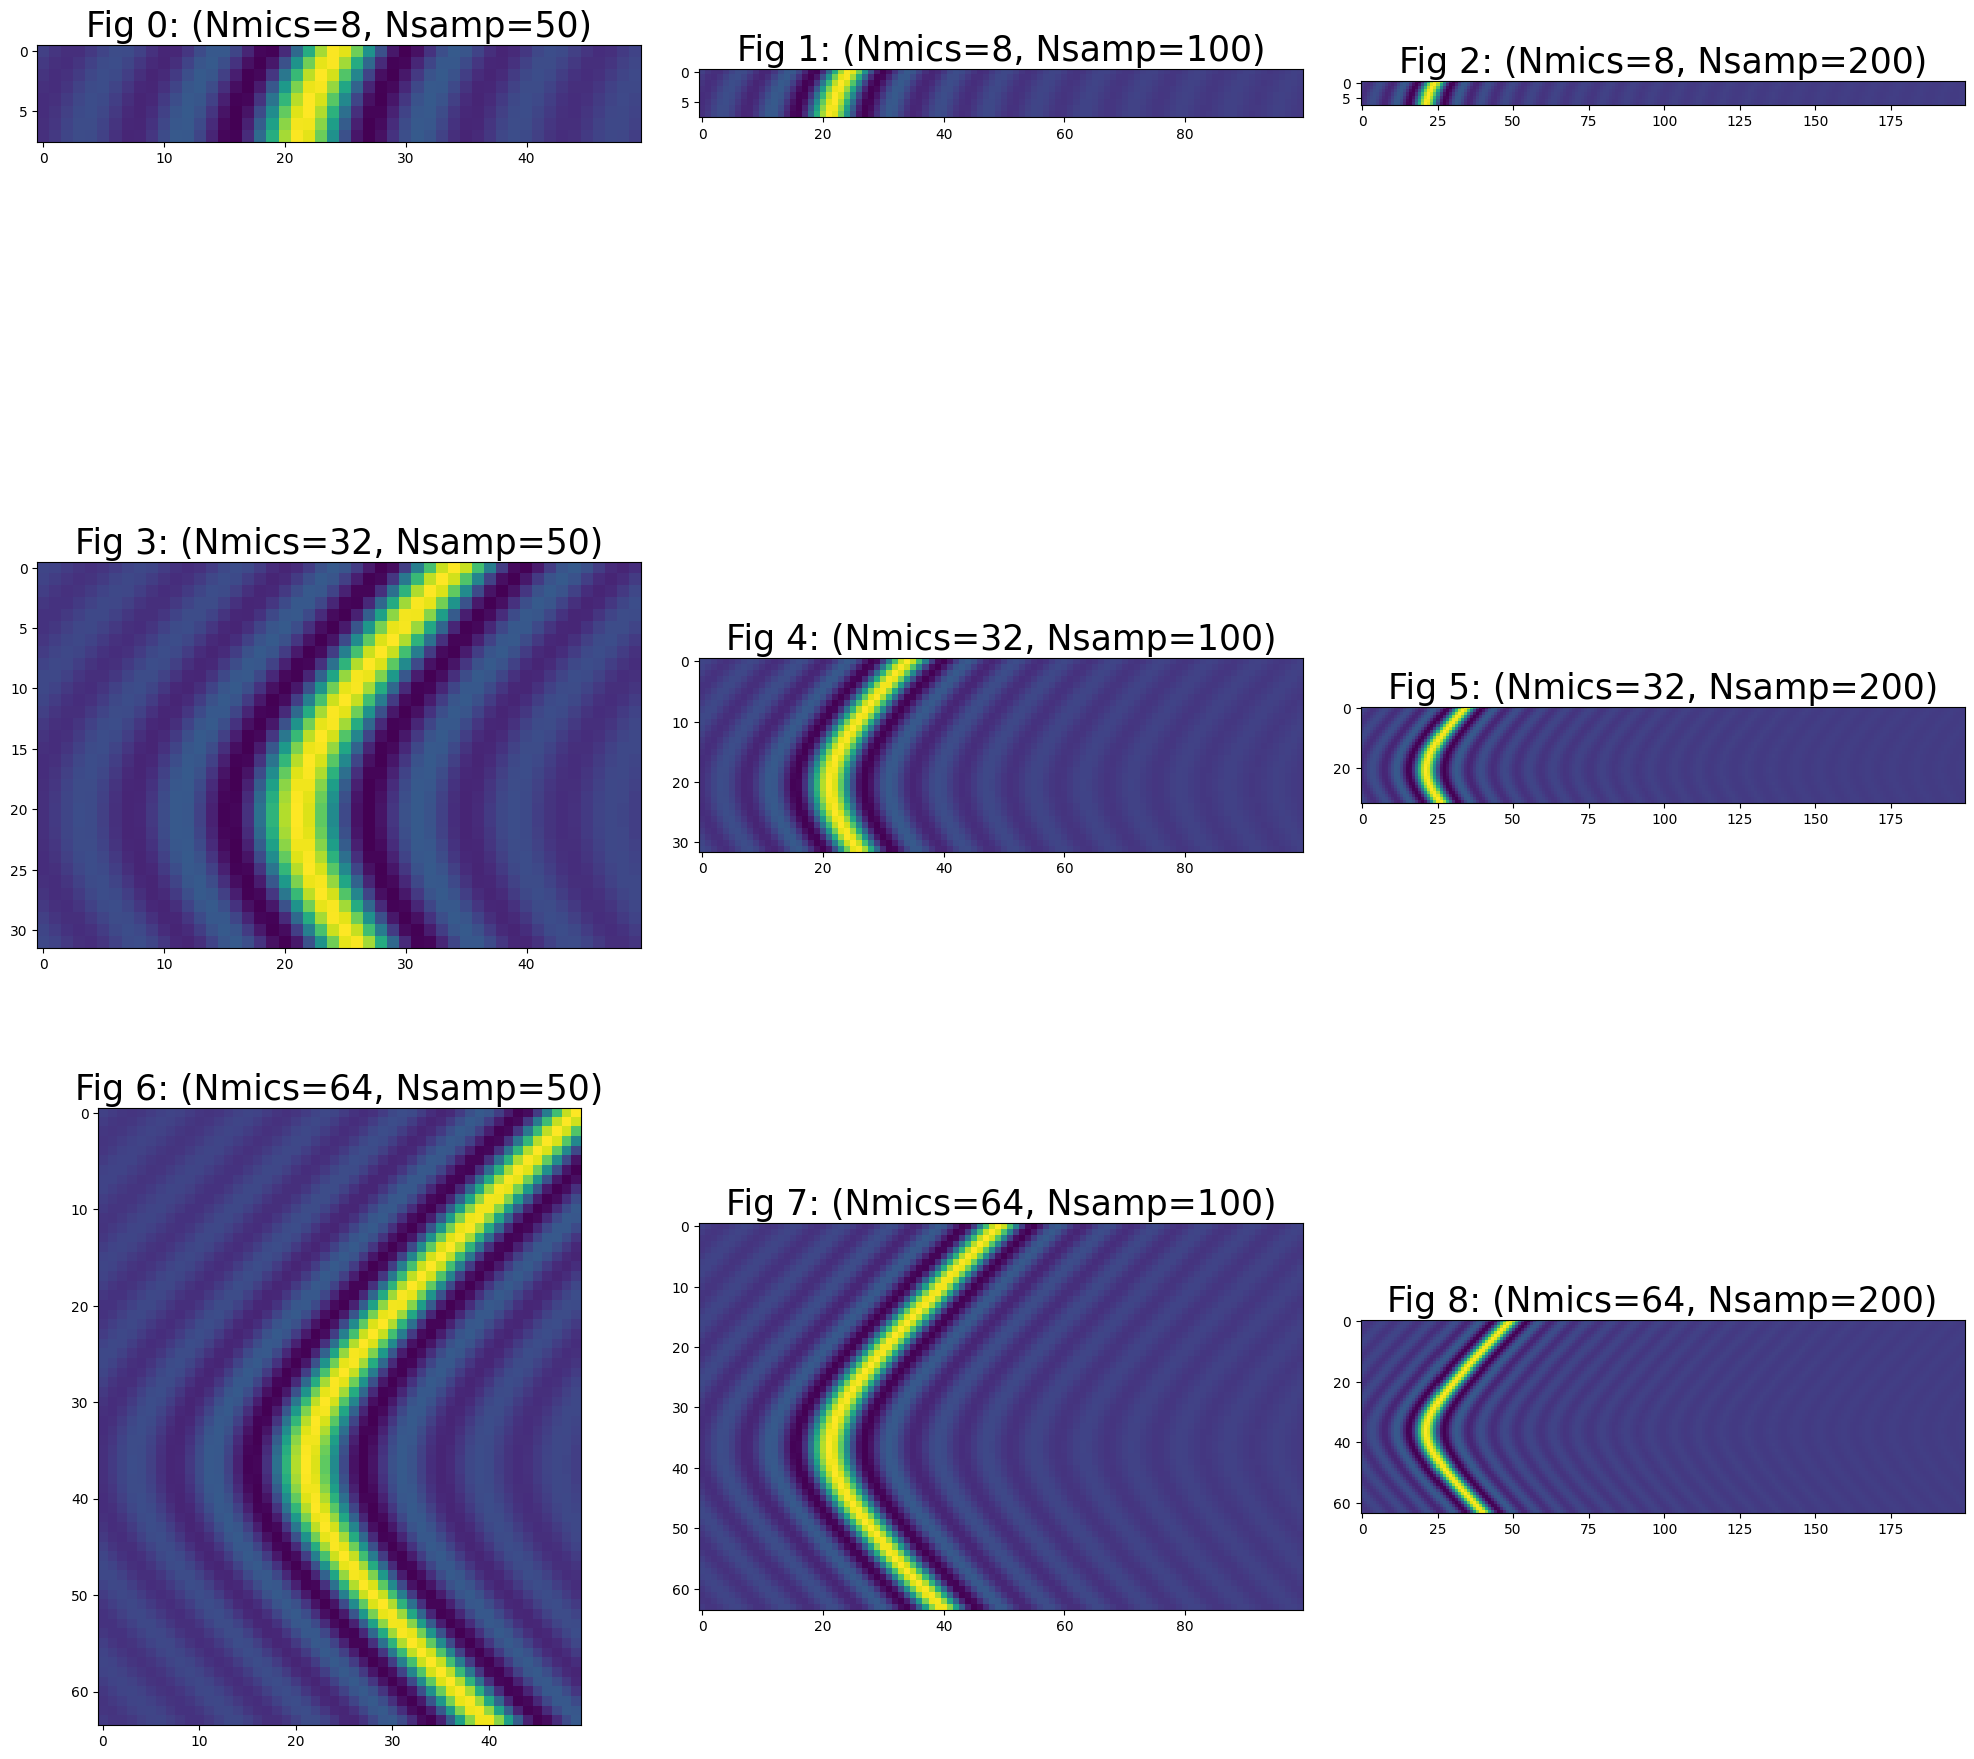

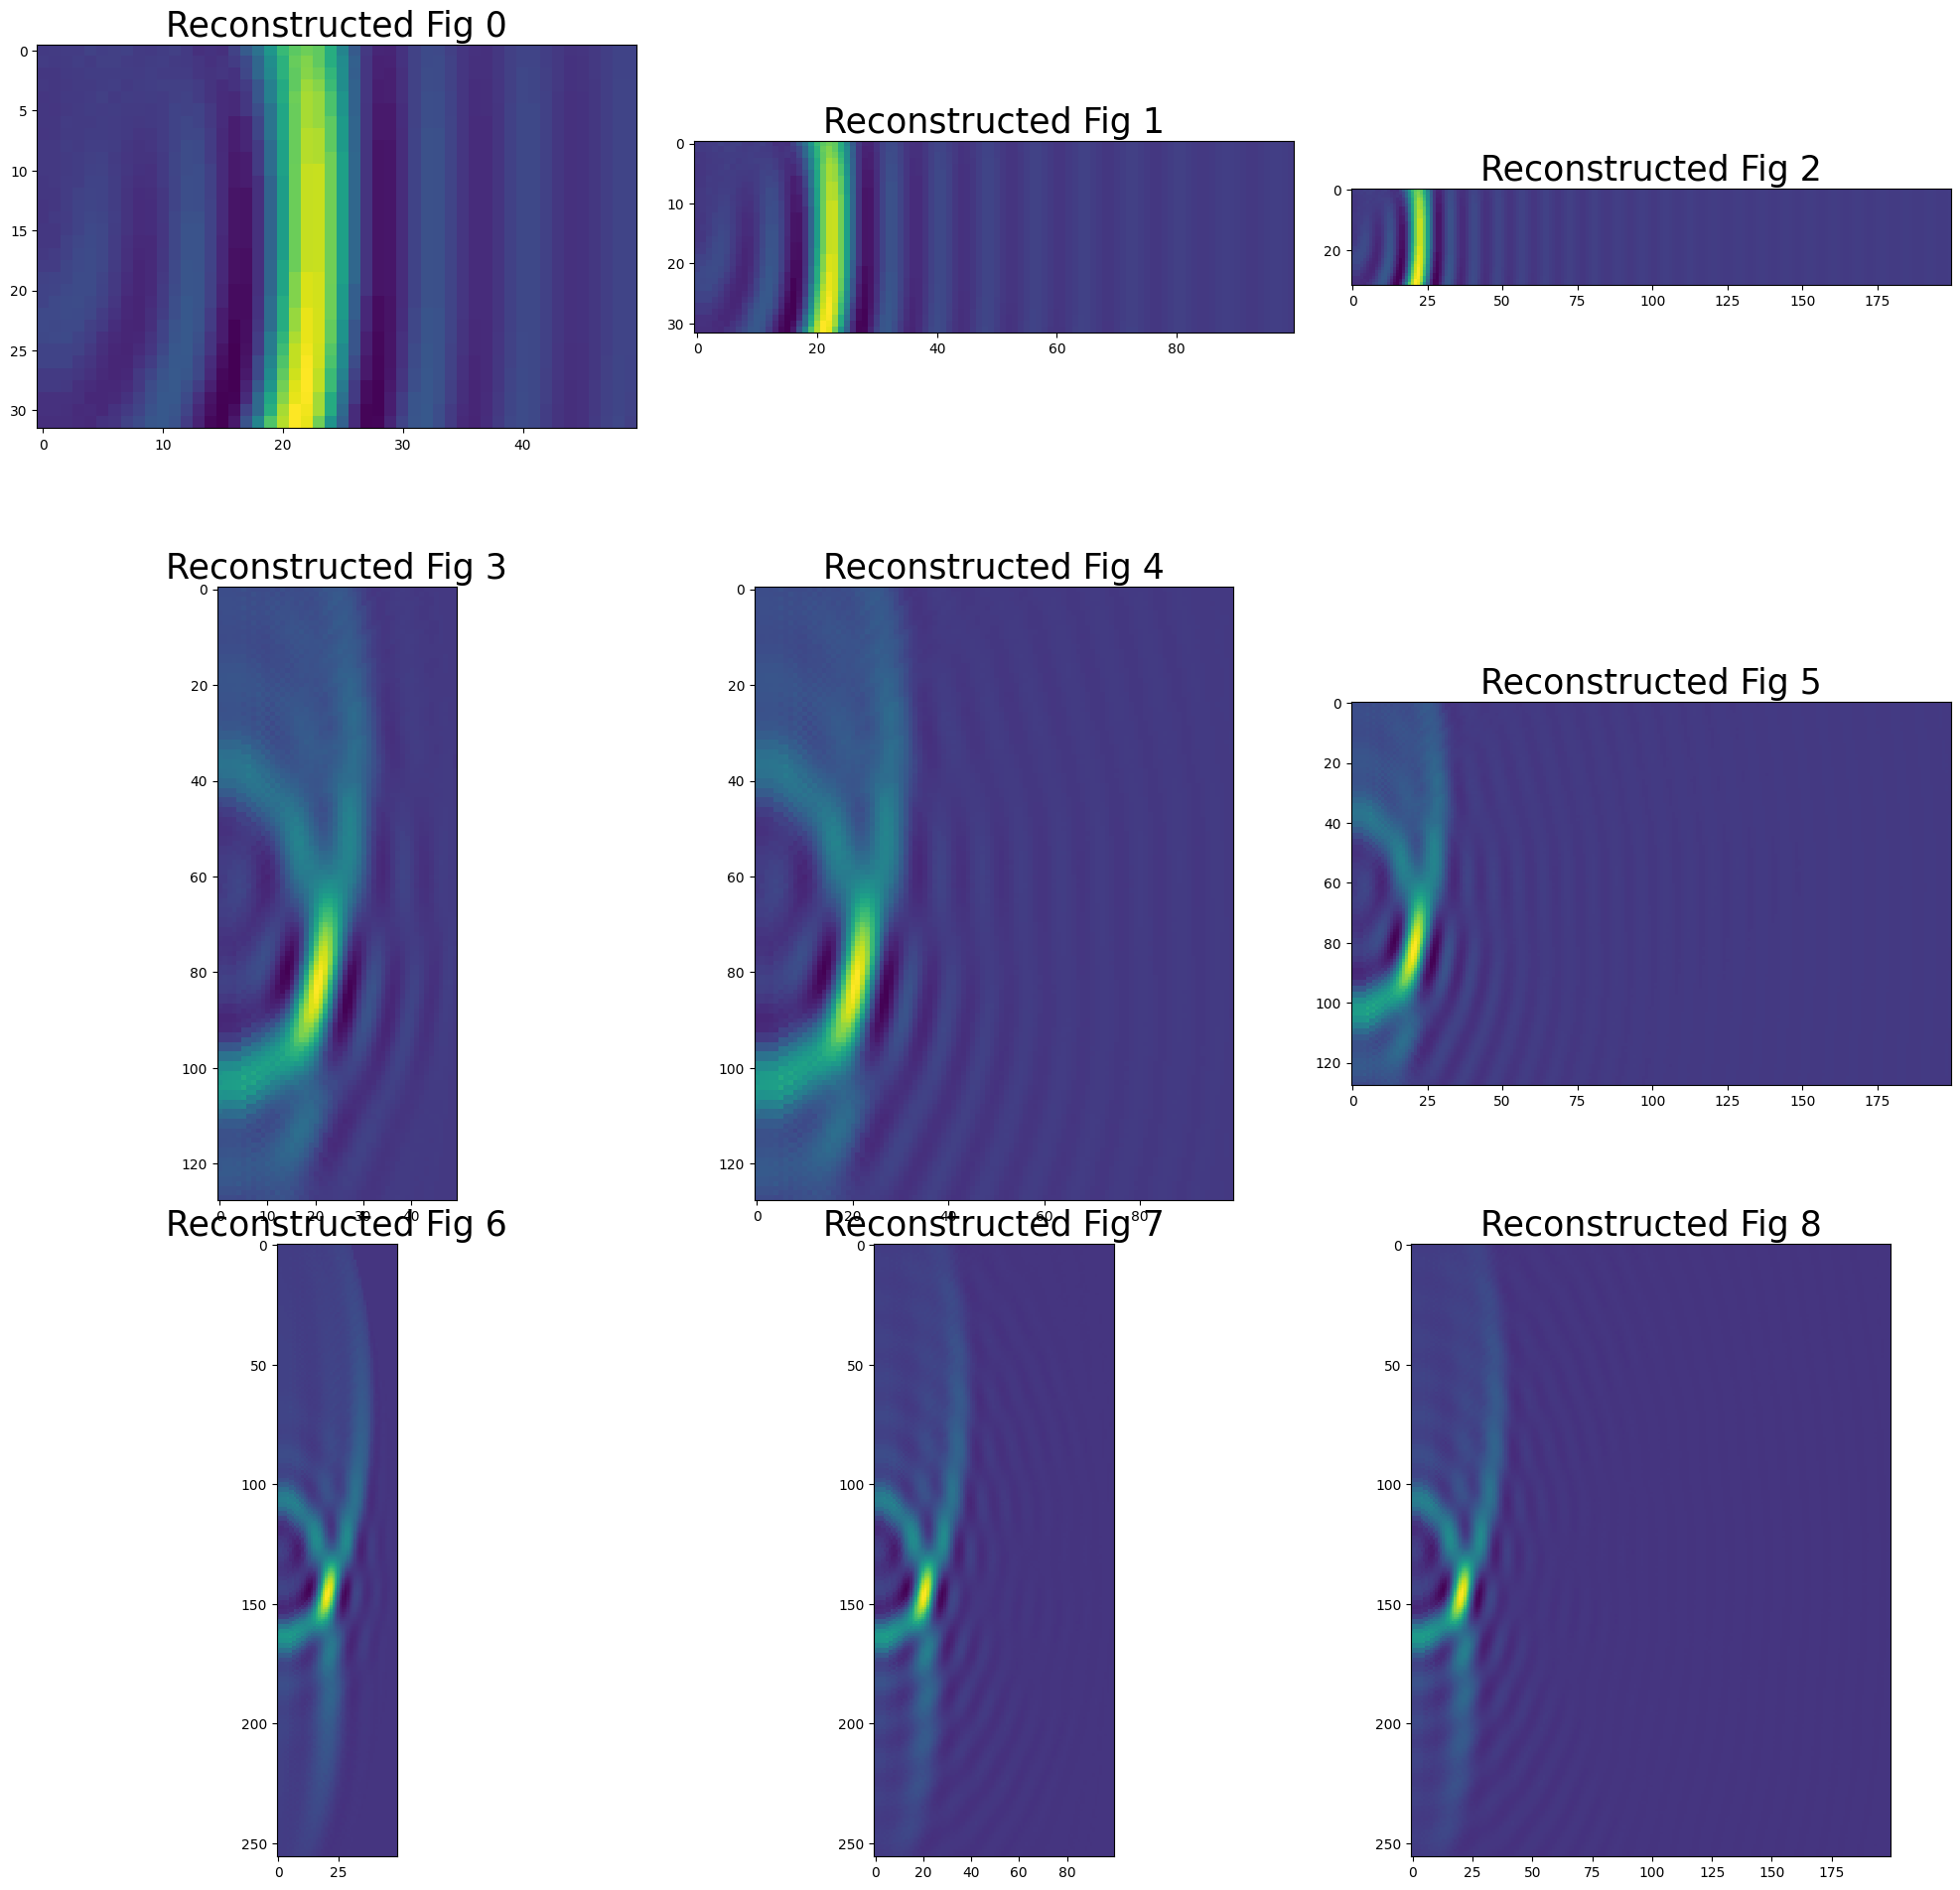

In [ ]:
Nmics_values = [8, 32, 64]
Nsamp_values = [50, 100, 200]

fig, subplots = plt.subplots(3, 3, figsize=(20,20), height_ratios=[1] * 3)
plt_idx = 0

fig2, subplots2 = plt.subplots(3, 3, figsize=(20,20), height_ratios=[1] * 3)

fig.tight_layout()
fig2.tight_layout()

for Nmics in Nmics_values:
    for Nsamp in Nsamp_values:
        _, reflected_rf = generate_waveform_data(
            Nmics=Nmics, Nsamp=Nsamp,
            obstacle=(1, 0.5)
        )
        subplots[plt_idx // 3, plt_idx % 3].set_anchor("C")
        subplots[plt_idx // 3, plt_idx % 3].set_title(f"Fig {plt_idx}: (Nmics={Nmics}, Nsamp={Nsamp})", fontsize=25) # type: ignore
        subplots[plt_idx // 3, plt_idx % 3].imshow( # type: ignore
            reflected_rf, 
            cmap='viridis', interpolation='nearest'
        )

        image = reconstruct_image(
            reflected_rf,
            # NOTE: Increasing resolution increases the number of points tested for (The image will look less pixelated but it will take more time)!
            resolution=(1, 1)
        )

        subplots2[plt_idx // 3, plt_idx % 3].set_anchor("C")
        subplots2[plt_idx // 3, plt_idx % 3].set_title(f"Reconstructed Fig {plt_idx}", fontsize=25) # type: ignore
        subplots2[plt_idx // 3, plt_idx % 3].imshow( # type: ignore
            image,
            cmap='viridis', interpolation='nearest'
        )
        plt_idx += 1